In [6]:
import os
import time
import sys
import scipy
import glob
import importlib
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [7]:
util.set_sns_style(style='dark', min_fontsize=12)
%matplotlib notebook

In [8]:
# rootdir = '/mnt/minerva/plume-tracking/behavior'
rootdir = '/Volumes/Julie/plume-tracking/behavior'
experiment = 'strip_grid'

srcdir = os.path.join(rootdir, experiment)
logdir = os.path.join(srcdir, 'logfiles')

figdir = os.path.join(srcdir, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print("Saving figures to: {}".format(figdir))

fig_id = srcdir

Saving figures to: /Volumes/Julie/plume-tracking/behavior/strip_grid/figures


In [9]:
# fn = '20230106-121556_strip_grid_fly1_000.log'

fns = [
    '20230126-175229_strip_grid_fly1_001.log',
    '20230112-155809_strip_grid_fly4_000.log',
    '20230112-110700_strip_grid_fly1_002.log',
    '20230111-140918_strip_grid_fly1_000.log',
    '20230105-182650_strip_grid_fly1_004.log',
    '20230106-121556_strip_grid_fly1_000.log'
]


In [10]:
fns

['20230126-175229_strip_grid_fly1_001.log',
 '20230112-155809_strip_grid_fly4_000.log',
 '20230112-110700_strip_grid_fly1_002.log',
 '20230111-140918_strip_grid_fly1_000.log',
 '20230105-182650_strip_grid_fly1_004.log',
 '20230106-121556_strip_grid_fly1_000.log']

In [11]:
import trajectory as traj

In [16]:
boutdir_palette = {'outbound': 'cyan', 'inbound': 'violet'} #'cyan'}

In [456]:
importlib.reload(butil)
importlib.reload(traj)

<module 'trajectory' from '/Users/julianarhee/Repositories/plume-tracking/trajectory.py'>

In [457]:
plot=False
params={}
d_list = []
t_list= []
for fn in fns:
    print(fn)
    fpath = os.path.join(logdir, fn)
    # load df and get odor strip info
    df0_full, oparams = traj.load_df(fpath)
    odor_ix = oparams['odor_ix']
    odor_bounds = oparams['odor_bounds']
    strip_width, strip_sep = oparams['strip_width'], oparams['strip_sep']
    fkey = os.path.splitext(fn)[0]
    params[fkey] = oparams

    # start from odor onset
    df0 = df0_full.loc[odor_ix:].copy()
    # find all ET bouts (in case there is more than 1)
    et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(df0, odor_bounds, 
                                    strip_width=strip_width, strip_sep=strip_sep)
    et_boutkey = traj.get_best_et_boutkey(et_boutstats)
    # select best ET
    df_best, odor_ix, et_bouts = traj.select_best_et_bout(et_boutkey, et_bouts, df0_full, strip_sep=strip_sep)

    # flip trajectory so all riding along strip's right side
    dfp, obounds_fp = traj.check_and_flip_traj(df_best, et_boutkey, et_boutstats, et_bouts,
                                               strip_width=strip_width)
    # get final DF
    df = dfp.loc[odor_ix:].copy()
    obounds = list(obounds_fp.values())
    params[fkey]['odor_bounds'] = obounds
    # calculate tortuosity metrics
    tortdf = traj.calculate_tortuosity_metrics(df, xdist_cutoff=1.9)
    tortdf['filename'] = fn
    
    if plot:
        fig = traj.plot_tortuosity_metrics(tortdf, cdf=False, boutdir_palette=boutdir_palette)
        util.label_figure(fig, "{}".format(fig_id))
        fig.text(0.1, 0.8, fn)
        pl.subplots_adjust(right=0.8)

    t_list.append(tortdf)
    d_list.append(df)

20230126-175229_strip_grid_fly1_001.log
0: starts instrip True
Aggregate: 2582.163611594164
curr et key: 0
Is ET: 0 True
0 69
5460 85336
Not flipping borders
0
20230112-155809_strip_grid_fly4_000.log
0 2 4 323.83493230039846 (2657, 40)
0: starts instrip True
Aggregate: 200.31255405062097
curr et key: 0
not et: 0
1 6 32 773.5841397149661 (33232, 40)
1: starts instrip True
Aggregate: 1785.1473143162707
curr et key: 0
Is ET: 1 True
4 33
27460 61004
0
20230112-110700_strip_grid_fly1_002.log
0 2 62 90.27456764266549 (29008, 40)
0: starts instrip True
Aggregate: 4706.748919728859
curr et key: 0
Is ET: 0 True
1 64 104 540.4039329849325 (20345, 40)
1: starts instrip True
Aggregate: 3280.019527270798
curr et key: 0
Is ET: 1 True
0 63
5488 47674
0
20230111-140918_strip_grid_fly1_000.log
0 2 4 291.41078597079127 (721, 40)
0: starts instrip True
Aggregate: 43.21722616440299
curr et key: 0
not et: 0
1 6 38 741.4144452364021 (37272, 40)
1: starts instrip True
Aggregate: 1706.6892898320332
curr et ke

/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


0 2 2 -16.579111935052993 (1225, 40)
0: starts instrip True
Aggregate: 215.80460219651997
curr et key: 0
not et: 0
1 4 56 203.35916597671547 (47932, 40)
1: starts instrip True
Aggregate: 4876.793612954191
curr et key: 0
Is ET: 1 True
2 58 58 423.42446466398496 (680, 40)
2: starts instrip True
Aggregate: 137.63346948239905
curr et key: 0
not et: 2
2 57
16851 76183
Not flipping borders
0


# trajectories

In [459]:
df0_all = pd.concat(d_list, axis=0).reset_index()

In [460]:
figdir

'/Volumes/Julie/plume-tracking/behavior/strip_grid/figures'

In [461]:
len(df0_all['filename'].unique())

6

<IPython.core.display.Javascript object>


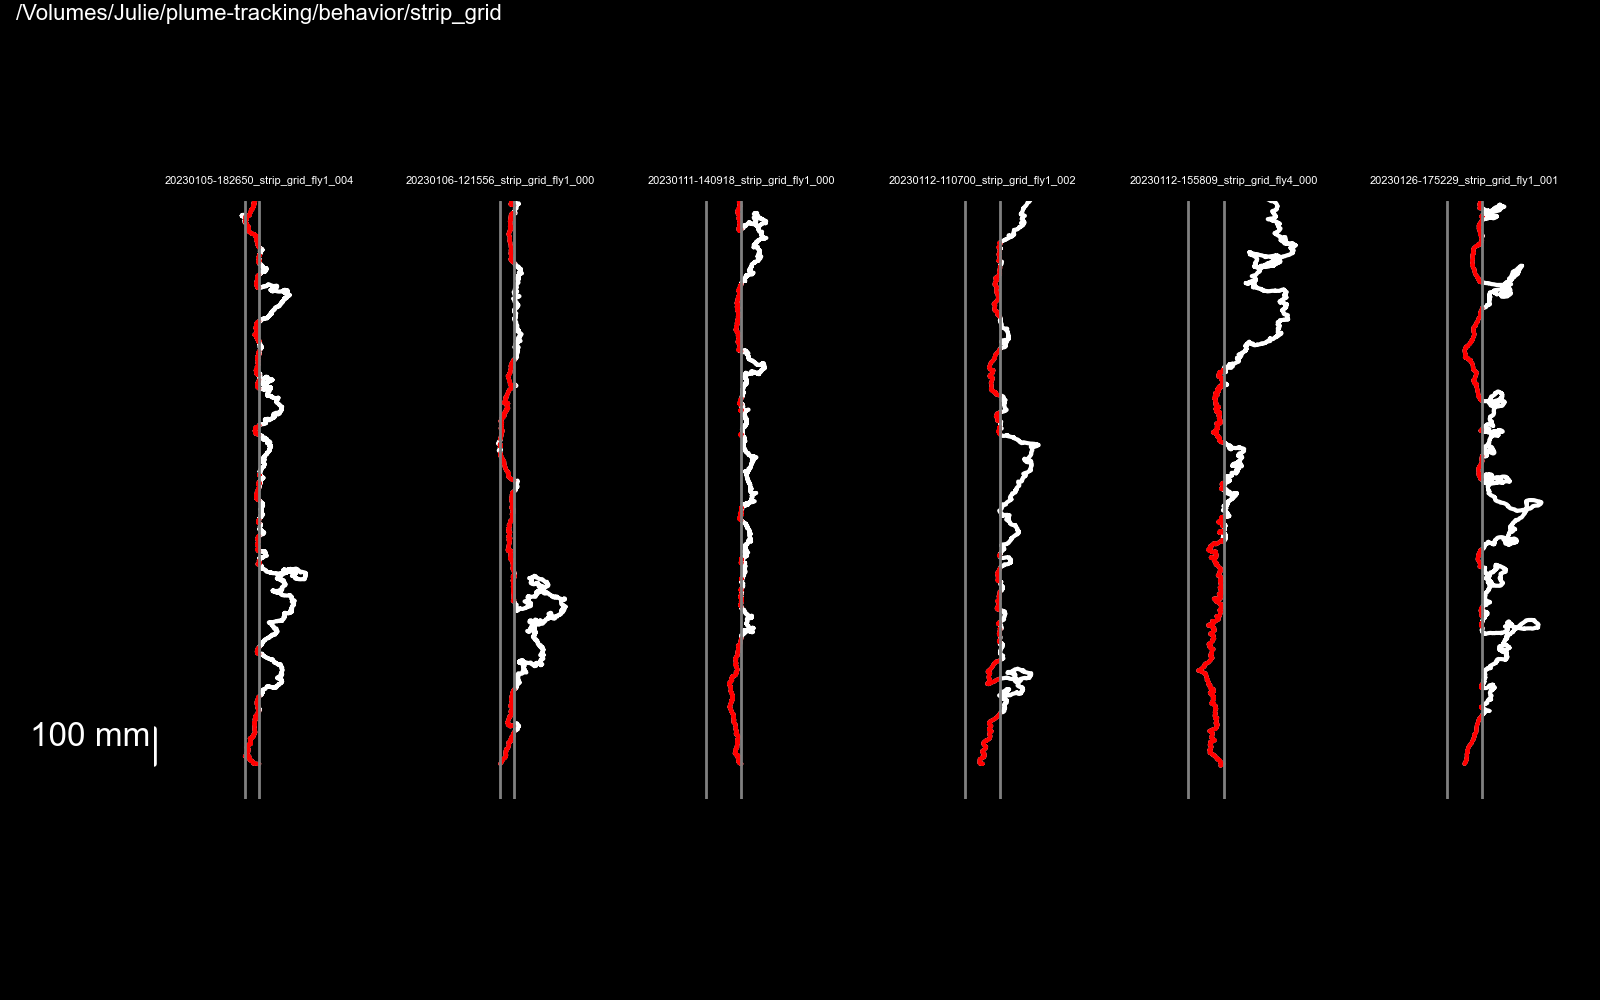

0 (-225.33645108718991, -245.44476537004087)
1 (83.20442544883613, 103.35916597671547)
2 (-491.4073904760247, -541.4144452364021)
3 (159.76161568199436, 109.72543235733451)
4 (-523.4244583061757, -573.5841397149661)
5 (41.919019125848045, 91.99314080550499)


In [516]:
nr=1
nc=6
fig, axn = pl.subplots(nr, nc, figsize=(8,5), sharex=True)
for fi, (fn, df_) in enumerate(df0_all.groupby('filename')):
    if fi >= nr*nc:
        break
    ax=axn.flat[fi]
    odor_ix = df_[df_['instrip']].iloc[0].name
    # Zero to oor start
    plotdf = df_.copy()
    offset_x = plotdf[plotdf['instrip']].iloc[0]['ft_posx']
    offset_y = plotdf[plotdf['instrip']].iloc[0]['ft_posy']
    plotdf['ft_posx'] = plotdf['ft_posx'].values - offset_x
    plotdf['ft_posy'] = plotdf['ft_posy'].values - offset_y
    odor_bounds = params[fn]['odor_bounds'].copy()
    # plot instrip/outstrip
    plotdf = plotdf.loc[odor_ix:].copy()
    ax.plot(plotdf['ft_posx'], plotdf['ft_posy'], lw=1.5, c='w')
    for bnum, b_ in plotdf[plotdf['instrip']].groupby('boutnum'):
        ax.plot(b_['ft_posx'], b_['ft_posy'], lw=1.5, c='r')
    # odor corridor
    for ob in odor_bounds:
        print(fi, ob)
        butil.plot_odor_corridor(ax, odor_xmin=ob[0]-offset_x, 
                             odor_xmax=ob[1]-offset_x, odor_linewidth=1)
    # legend
    ax.axis('off')
    if fi==0:
        leg_xpos=-150; leg_ypos=0; leg_scale=100
        butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos)
    #ax.set_box_aspect(3)
    ax.set_xlim([-150, 150])
    ax.set_ylim([-100, 1600])
    ax.set_aspect(0.5)
    
    ax.set_title(fn, fontsize=4)

pl.tight_layout()
#pl.subplots_adjust(top=0.85, hspace=0.4, wspace=0.5) #left=0.1, right=0.9, wspace=1, hspace=1, bottom=0.1, top=0.8)

util.label_figure(fig, fig_id)

figname = '{}-traj-together'.format(nr*nc)
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))


In [513]:
ax.

'auto'

# tortuosity

In [464]:
tdf = pd.concat(t_list, axis=0).reset_index(drop=True)


In [465]:
tdf.columns

Index(['boutnum', 'boutdir', 'pathlength', 'tortuosity', 'xpath_length',
       'efficiency', 'maxdist_x', 'max_xpos', 'max_ix', 'filename'],
      dtype='object')

In [466]:
meandf = tdf.groupby(['filename', 'boutdir']).mean().reset_index()
meandf.head()

,filename,boutdir,boutnum,pathlength,tortuosity,xpath_length,efficiency,maxdist_x,max_xpos,max_ix
0,20230105-182650_strip_grid_fly1_004.log,inbound,37.285714,85.264285,2.576079,52.116264,2.766830,17.734417,-209.524428,1235.357143
1,20230105-182650_strip_grid_fly1_004.log,outbound,37.285714,113.195486,2.862909,68.688990,3.393484,17.734417,-209.524428,1235.357143
2,20230106-121556_strip_grid_fly1_000.log,inbound,29.173913,92.652543,2.021976,49.261566,3.086846,12.311317,113.488092,833.956522
3,20230106-121556_strip_grid_fly1_000.log,outbound,29.173913,130.942134,1.840544,68.481692,4.166853,12.311317,113.488092,833.956522
4,20230111-140918_strip_grid_fly1_000.log,inbound,22.777778,111.417576,3.011359,61.648971,4.300393,15.884275,-475.585274,1880.222222


In [473]:
import scipy.stats as spstats

<IPython.core.display.Javascript object>


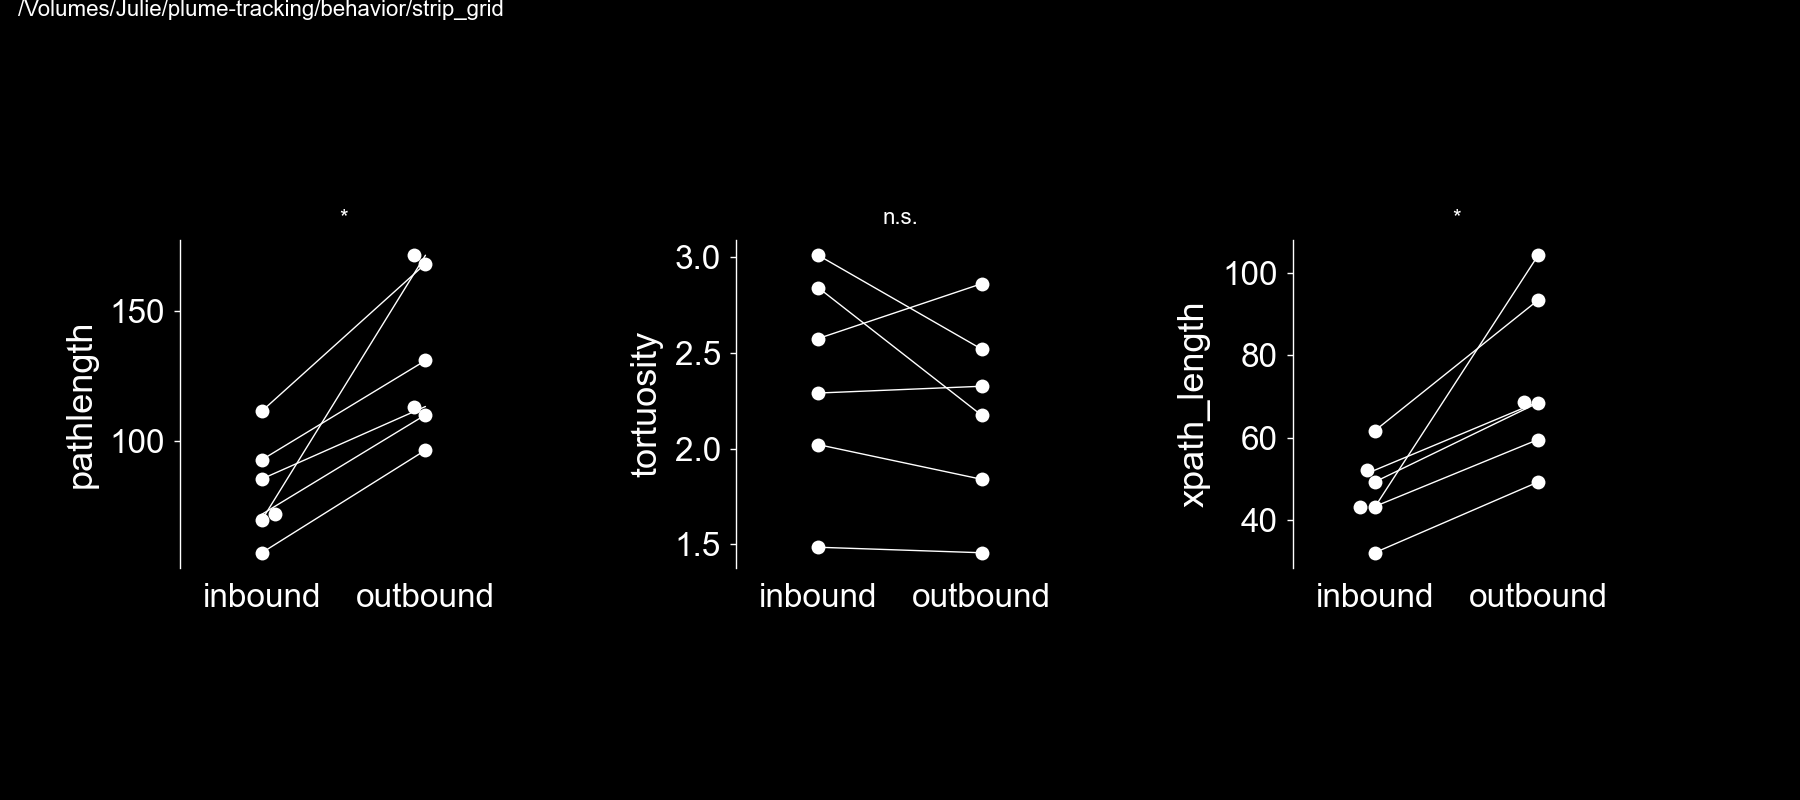

pathlength: wilcoxon signed rank, t(0.00), p=0.03
tortuosity: wilcoxon signed rank, t(6.00), p=0.44
xpath_length: wilcoxon signed rank, t(0.00), p=0.03


In [476]:
fig, axn = pl.subplots(1, 3, figsize=(9,4))

varnames = ['pathlength', 'tortuosity', 'xpath_length']
for ax, varname in zip(axn.flat, varnames):
    sns.swarmplot(data=meandf, y=varname, x='boutdir', ax=ax, c='w')
    for f, fd in meandf.groupby('filename'):
        ax.plot([0, 1],
                [fd[fd['boutdir']=='inbound'][varname], fd[fd['boutdir']=='outbound'][varname]],
                'w', lw=0.5)
    ax.set_box_aspect(1)
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
                   direction='out', left=True)
    for pos in ['right', 'top', 'bottom']:
       ax.spines[pos].set_visible(False)
    ax.set_xlabel('')
    ax.set_xlim([-0.5, 1.5])

    # stats
    a = meandf[meandf['boutdir']=='inbound'][varname].values
    b = meandf[meandf['boutdir']=='outbound'][varname].values
    pdf = pd.DataFrame({'a': a, 'b': b})
    T, pv = spstats.wilcoxon(pdf["a"], pdf["b"], nan_policy='omit')
    if pv>=0.05:
        star = 'n.s.'
    else:
        star = '**' if pv<0.01 else '*'
    ax.set_title(star, fontsize=8)
    print("{}: wilcoxon signed rank, t({:.2f}), p={:.2f}".format(varname, T, pv))
    
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.7)

util.label_figure(fig, fig_id)
pl.savefig(os.path.join(figdir, 'all-flies-summary-tortuosity.png'))

In [480]:
tortdf.shape

(46, 10)

In [488]:
tdf.groupby('filename')['boutnum'].count()

filename
20230105-182650_strip_grid_fly1_004.log    28
20230106-121556_strip_grid_fly1_000.log    46
20230111-140918_strip_grid_fly1_000.log    18
20230112-110700_strip_grid_fly1_002.log    48
20230112-155809_strip_grid_fly4_000.log    20
20230126-175229_strip_grid_fly1_001.log    50
Name: boutnum, dtype: int64

In [509]:
tdf.columns

Index(['boutnum', 'boutdir', 'pathlength', 'tortuosity', 'xpath_length',
       'efficiency', 'maxdist_x', 'max_xpos', 'max_ix', 'filename'],
      dtype='object')

<IPython.core.display.Javascript object>


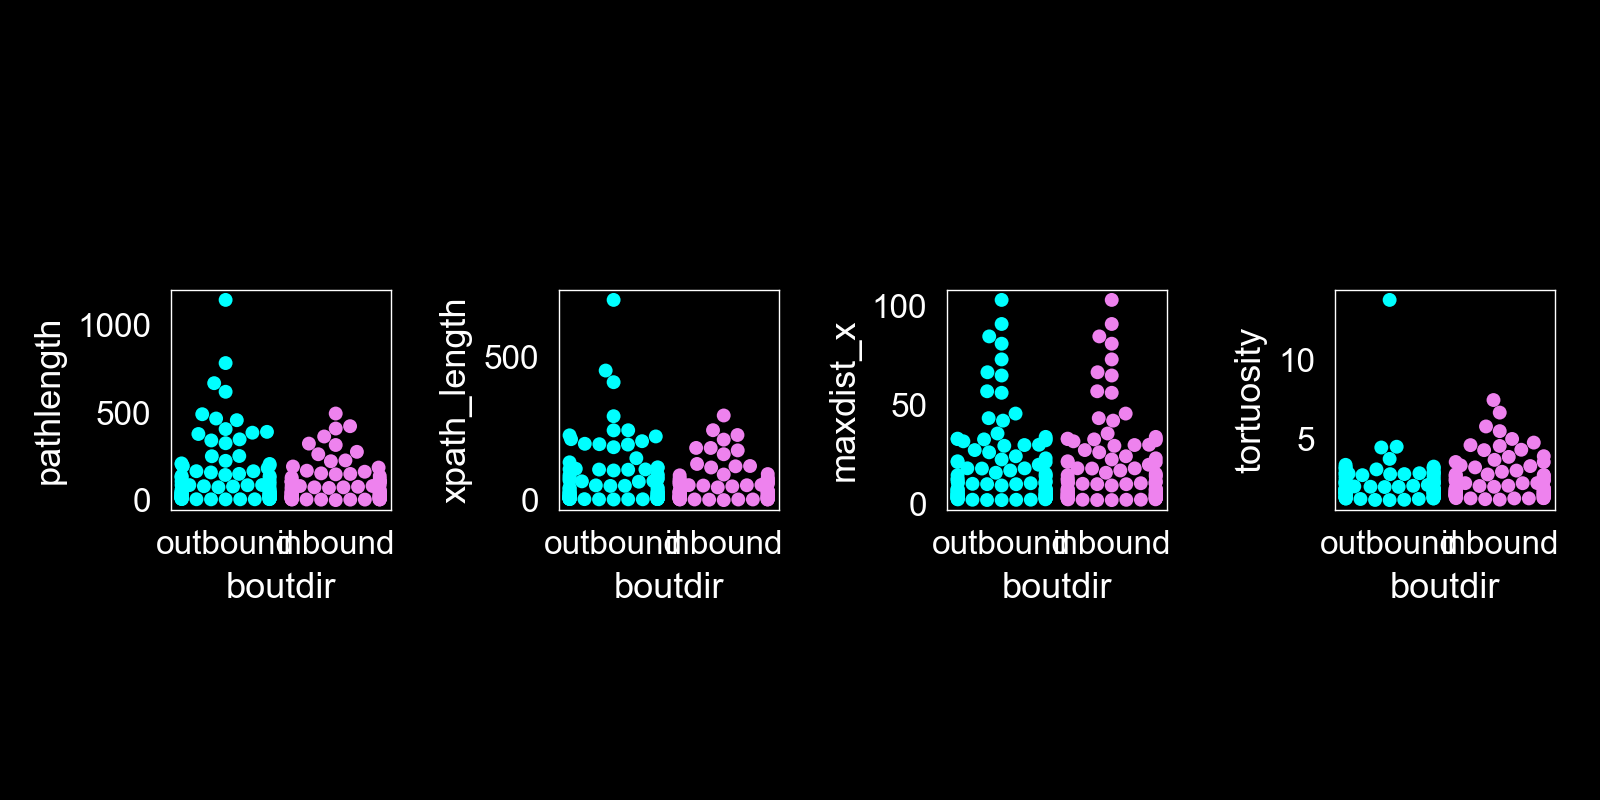

/Users/julianarhee/miniforge3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/julianarhee/miniforge3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/julianarhee/miniforge3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/julianarhee/miniforge3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:3540: UserWarning: 68.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [511]:
varnames = ['pathlength', 'xpath_length', 'maxdist_x', 'tortuosity']

fig, axn = pl.subplots(1, len(varnames), figsize=(2*len(varnames), 4))

for ai, (ax, varn) in enumerate(zip(axn.flat, varnames)):
    sns.swarmplot(data=tdf, y=varn, x='boutdir', hue='boutdir', palette=boutdir_palette, ax=ax)

    #sns.move_legend(ax, "lower left", bbox_to_anchor=(1.05, 1), frameon=False, ncols=2)
    ax.legend_.remove()
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=1)
pl.tight_layout()

<IPython.core.display.Javascript object>


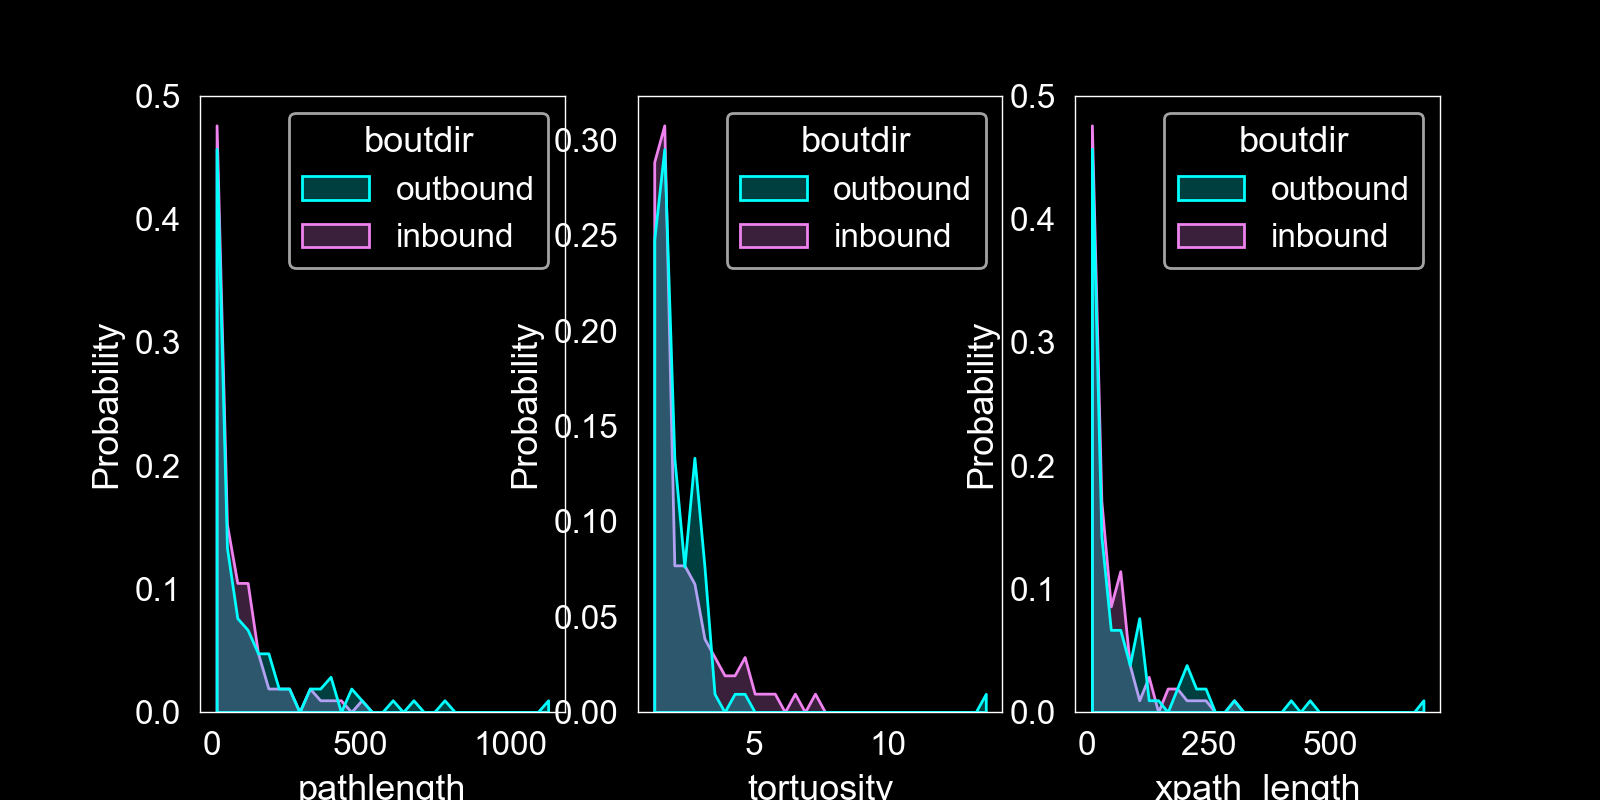

In [471]:
fig, axn = pl.subplots(1, 3, figsize=(8,4))
for ax, varname in zip(axn.flat, varnames):
    sns.histplot(data=tdf, x=varname, hue='boutdir', ax=ax, palette=boutdir_palette,
            common_norm=False, stat='probability', element='poly', cumulative=False)

<IPython.core.display.Javascript object>


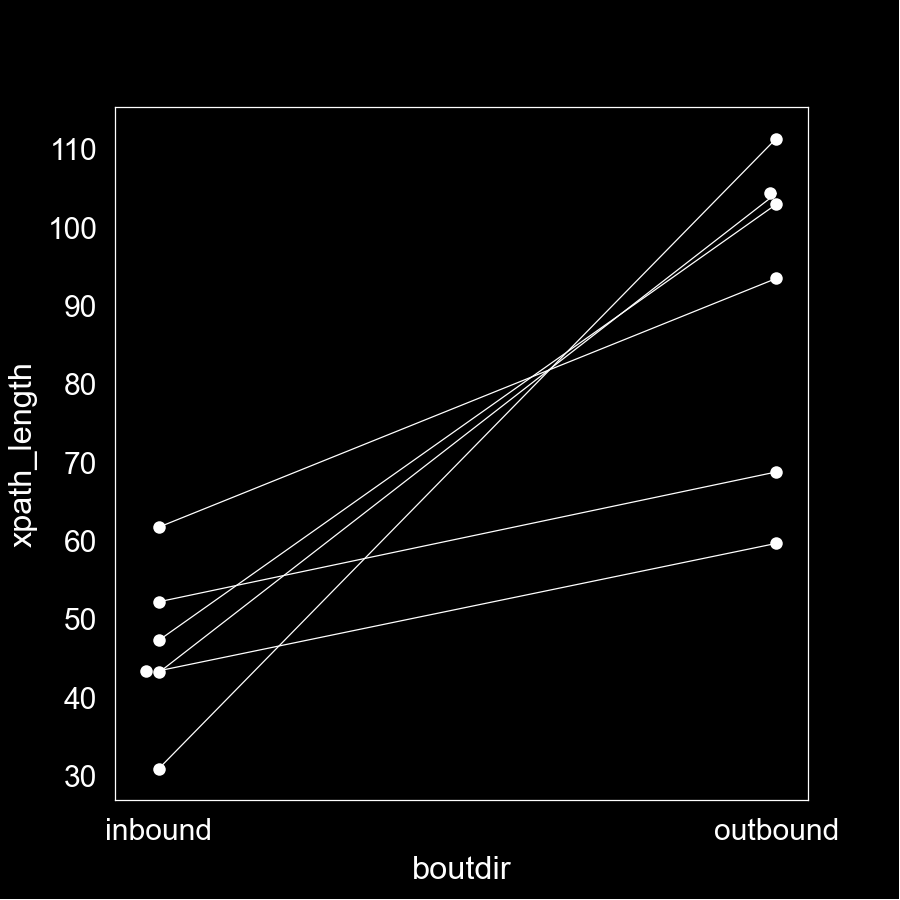

In [108]:
varname = 'xpath_length'
fig, ax = pl.subplots(figsize=(5,5))
#sns.pointplot(data=meandf, y='xpath_length', x='boutdir', ax=ax, markers='_')
sns.swarmplot(data=meandf, y=varname, x='boutdir', ax=ax, c='w')

for f, fd in meandf.groupby('filename'):
    ax.plot([0, 1],
            [fd[fd['boutdir']=='inbound'][varname], fd[fd['boutdir']=='outbound'][varname]],
            'w', lw=0.5)
ax.set_box_aspect(1)

In [95]:
fd

,filename,boutdir,boutnum,pathlength,tortuosity,xpath_length,efficiency,maxdist_x,max_xpos,max_ix
10,20230126-175229_strip_grid_fly1_001.log,inbound,35.32,71.628604,2.291359,43.307983,1.646904,22.597829,114.58361,1391.12
11,20230126-175229_strip_grid_fly1_001.log,outbound,35.32,109.985506,2.326835,59.568674,2.325579,22.597829,114.58361,1391.12


In [51]:
boutdir_palette = {'outbound': 'cyan', 'inbound': 'violet'} #'cyan'}

<IPython.core.display.Javascript object>


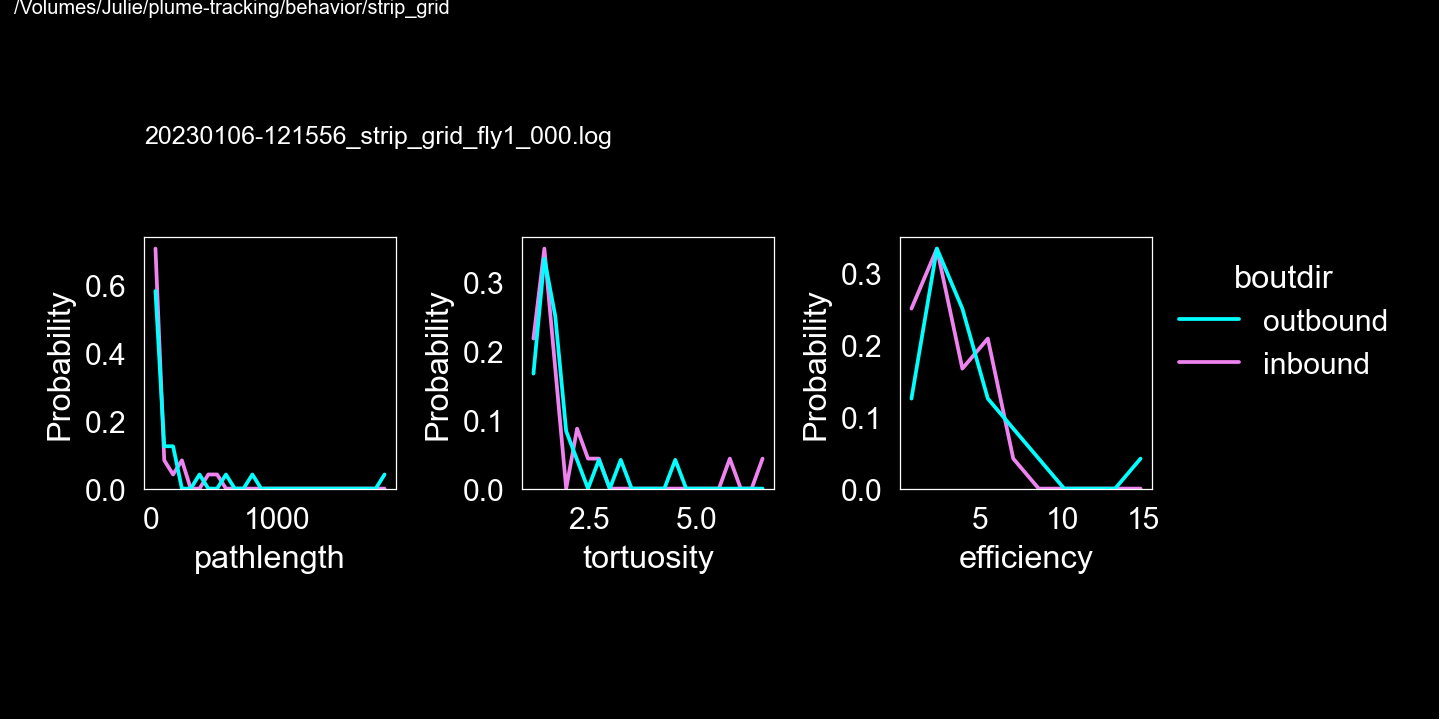

In [60]:


fig = plot_tortuosity_metrics(tortdf, cdf=False, boutdir_palette=boutdir_palette)
util.label_figure(fig, "{}".format(fig_id))
fig.text(0.1, 0.8, fn)
pl.subplots_adjust(right=0.8)
# figname = 'tortuosity-metrics-hist_{}'.format(os.path.splitext(fn)[0])
# print(figname)
# pl.savefig(os.path.join(figdir, '{}.png'.format(figname)), dpi=300)